# 6. Transfer learning

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torch.utils.data import DataLoader
from IPython.display import clear_output
from early_stopping.pytorchtools import EarlyStopping

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


plt.rcParams['text.color'] = 'w'
plt.rcParams['xtick.color'] = 'w'
plt.rcParams['ytick.color'] = 'w'
plt.rcParams['axes.labelcolor'] = 'w'
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

Files already downloaded and verified


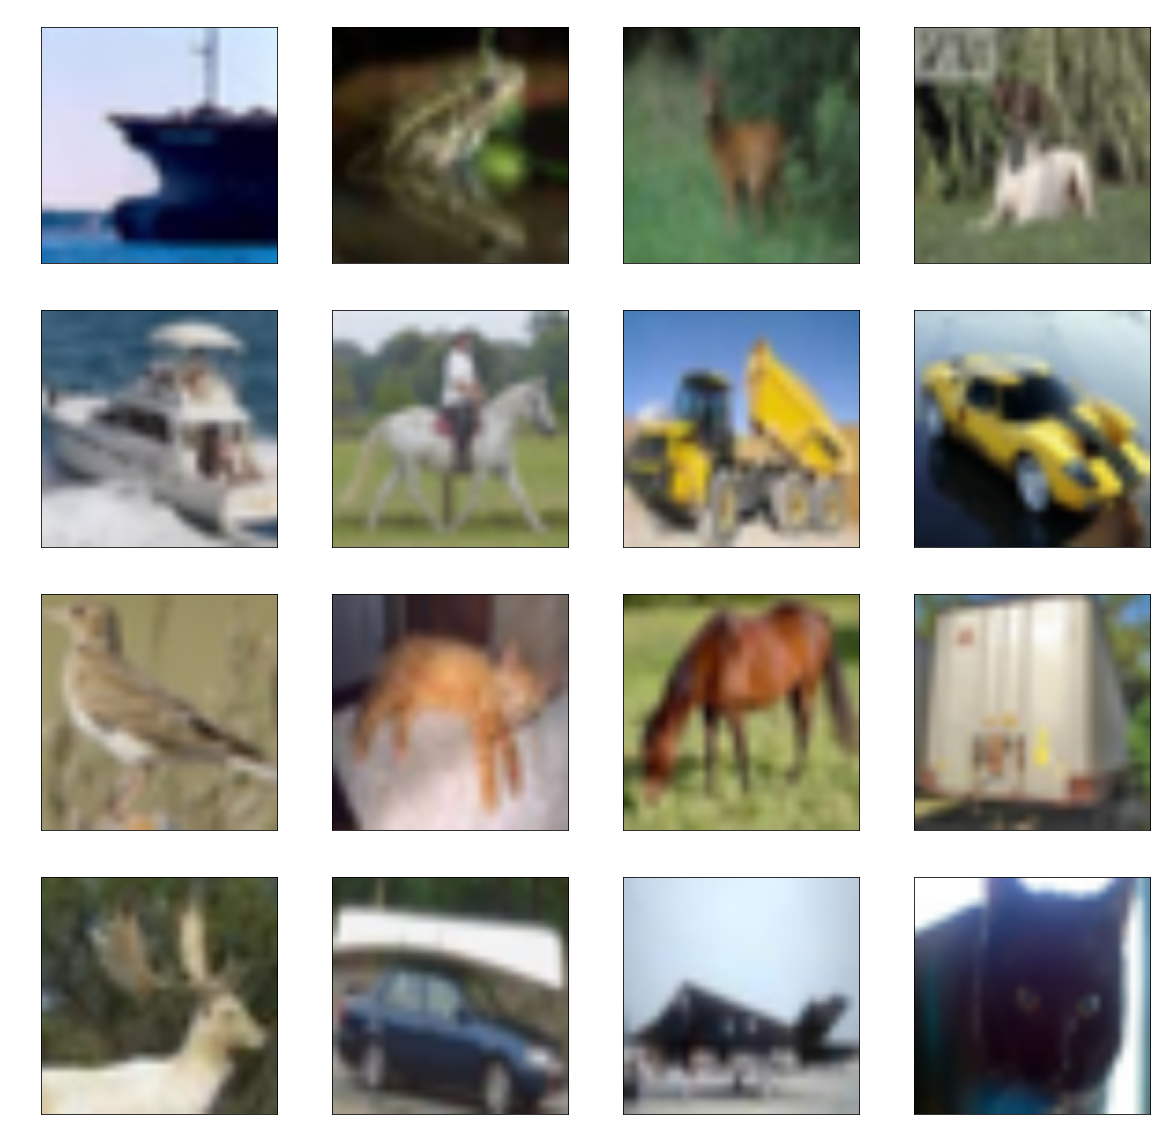

In [2]:
min_transform = torchvision.transforms.Compose([
                                    torchvision.transforms.Resize((128,128)),
                                    torchvision.transforms.ToTensor()
                                    ])
dataset = torchvision.datasets.CIFAR10("/media/miro/4tb_cached/",
                                       transform=min_transform,
                                       download=True)

fig, axs = plt.subplots(4, 4,figsize=(20,20))
sample = np.random.randint(0,len(dataset),64)
for i in range(16):
    img, target = dataset.__getitem__(sample[i])
    img = img.permute(1,2,0)
    axs[i//4,i%4].imshow(img)
    axs[i//4,i%4].set_title("{} min: {:.2f} max: {:.2f}".format(dataset.classes[target],torch.min(img),torch.max(img)))

In [3]:
batch_size =  8
split = (0.4, 0.3, 0.3)
training_samples = int(len(dataset) * split[0])
validation_samples = int(len(dataset) *  split[1])
test_samples = len(dataset) - training_samples - validation_samples
train_ds, valid_ds, test_ds = torch.utils.data.random_split(dataset, (training_samples, validation_samples, test_samples))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [4]:
def train(model, n_epochs,train_loader,valid_loader,criterion,optimizer,scheduler=None,early_stop_count=0):
    avg_train_losses = []
    avg_valid_losses = []
    avg_valid_acc = []
    batch_train_losses= []

    early_stopping = EarlyStopping(patience=early_stop_count, verbose=True, path="net.pth")

    for epoch in range(1, n_epochs + 1):
        train_losses = []
        valid_losses = []
        valid_accs = []

        model.train() # prep model for training
        for input_data, classes in train_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        for input_data, classes in valid_loader:
            data = input_data.to(device)
            target = classes.long().to(device)

            output = model(data)
            loss = criterion(output, target)
            valid_losses.append(loss.item())

            _, pred = torch.max(output, 1)

            valid_accs.append(np.sum(target.cpu().numpy() == pred.cpu().numpy()) / pred.shape[0])



        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        valid_acc = np.average(valid_accs)

        if scheduler:
            scheduler.step()

        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        avg_valid_acc.append(valid_acc)
        batch_train_losses.extend(train_losses)

        epoch_len = len(str(n_epochs))

        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f} '
                     f'valid_acc: {valid_acc*100:2.2f} %')
        if scheduler:
            print_msg = print_msg + " lr: {:.5f}".format(scheduler.get_last_lr()[0])
        print(print_msg)

        if early_stop_count:
            early_stopping(valid_loss, model)

            if early_stopping.early_stop:
                print("Early stopping")
                break
    if early_stop_count:
        model.load_state_dict(torch.load("net.pth"))

    return avg_valid_losses, avg_train_losses, model, batch_train_losses

In [5]:
def print_accuracy(model, criterion, test_loader):
    y_gts = np.array([])
    y_preds = np.array([])
    for input_data, classes in test_loader:
        x = input_data.to(device)
        y = classes.long().to(device)
        output = model(x)
        _, pred = torch.max(output, 1)

        y_gts = np.hstack((y_gts, y.cpu().numpy()))
        y_preds = np.hstack((y_preds, pred.cpu().numpy()))

    print("Accuracy the NN is : {:2.2f} %".format(np.sum(y_gts==y_preds)/y_preds.shape[0]*100))


def visualize_batch_loss(batch_train_losses):
    plt.figure(figsize=(15,3))
    xx = np.arange(0,len(batch_train_losses),1)
    y_train =  np.array(batch_train_losses)
    plt.plot(xx, y_train)
    plt.legend(["Training Loss"],labelcolor='black')
    plt.xlabel("Batches")
    plt.ylabel("Loss")
    plt.title("Loss of validation and training set")
    plt.show()

def visualize_loss(avg_valid_losses,avg_train_losses):
    plt.figure()
    xx = np.arange(0,len(avg_valid_losses),1)
    y_valid = np.array(avg_valid_losses)
    y_train =  np.array(avg_train_losses)
    plt.plot(xx, y_valid)
    plt.plot(xx, y_train,color='red')
    plt.legend(("Validation Loss","Training Loss"),labelcolor='black')
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    plt.title("Loss of validation and training set")
    plt.show()

## ResNet 18

In [6]:
from torchsummary import summary

model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

summary(model, input_size=(3, 224, 224),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

### 1. ConvNet as fixed feature extractor:
* load ResNet
* input size should 224 by 224, but avg pool helps
* http://www.image-net.org/index
* https://paperswithcode.com/sota/image-classification-on-imagenet

In [7]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 10)
)

model.fc.requires_grad = True # not neccesary

model = model.to(device)
summary(model, input_size=(3, 128, 128),batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [32, 64, 64, 64]           9,408
       BatchNorm2d-2           [32, 64, 64, 64]             128
              ReLU-3           [32, 64, 64, 64]               0
         MaxPool2d-4           [32, 64, 32, 32]               0
            Conv2d-5           [32, 64, 32, 32]          36,864
       BatchNorm2d-6           [32, 64, 32, 32]             128
              ReLU-7           [32, 64, 32, 32]               0
            Conv2d-8           [32, 64, 32, 32]          36,864
       BatchNorm2d-9           [32, 64, 32, 32]             128
             ReLU-10           [32, 64, 32, 32]               0
       BasicBlock-11           [32, 64, 32, 32]               0
           Conv2d-12           [32, 64, 32, 32]          36,864
      BatchNorm2d-13           [32, 64, 32, 32]             128
             ReLU-14           [32, 64,

In [8]:
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)

criterion_CE = torch.nn.CrossEntropyLoss()
avg_valid_losses, avg_train_losses, model,batch_train_losses = train(model,5,train_loader,valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer)
visualize_loss(avg_valid_losses,avg_train_losses)
visualize_batch_loss(batch_train_losses=batch_train_losses)

print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

[1/5] train_loss: 1.05818 valid_loss: 0.74137 valid_acc: 75.38 %
[2/5] train_loss: 0.92381 valid_loss: 0.73132 valid_acc: 76.13 %


KeyboardInterrupt: 

### 2. Fine-tuning the ConvNet.
#### A. Fine tuning full CNN

In [ ]:
from efficientnet_pytorch.model import EfficientNet

model = EfficientNet.from_pretrained('efficientnet-b0')

model = model.to(device)
summary(model, input_size=(3, 128, 128),batch_size=8)

In [ ]:
num_ftrs = model._fc.out_features
model.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(num_ftrs, 10))


optimizer =torch.optim.Adam(model.parameters(), lr=0.0001)
model = model.to(device)

In [ ]:
criterion_CE= torch.nn.CrossEntropyLoss()
avg_valid_losses, avg_train_losses, model,batch_train_losses = train(model,5,train_loader,valid_loader,
                                                                     criterion=criterion_CE,
                                                                     optimizer=optimizer)
visualize_loss(avg_valid_losses,avg_train_losses)
visualize_batch_loss(batch_train_losses=batch_train_losses)

print_accuracy(model,
               criterion=criterion_CE,
               test_loader=test_loader)

### 3. Pretrained models.
* https://modelzoo.co/
* https://github.com/

Uloha1.: Ako zmenit trenovaciu slucku aby som dokazal na 4Gb grafickej karte trenovat EfficientNet-B9 so vstupom 64x3x224x224. Zmenu implementujte. (5b)

Uloha2.: Naucte siet podla vlastneho vyberu s predtrenovanymi konvolucnymi maskami na CIFAR 10 bud ako fixny extraktor alebo vyladenie celej konvolucnej siete.